# MNIST

## Setup

In [1]:
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = os.getcwd()

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Data gathering

In [2]:
import scipy.io
mnist = scipy.io.loadmat('mnist-original.mat')
mnist['data']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
mnist.keys() 

dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])

In [22]:
mnist['data'].shape

(784, 70000)

In [19]:
mnist['label']

array([[0., 0., 0., ..., 9., 9., 9.]])

In [3]:
X, y = mnist["data"].transpose(), mnist["label"].transpose().ravel()
y.shape

(70000,)

Saving figure some_digit_plot


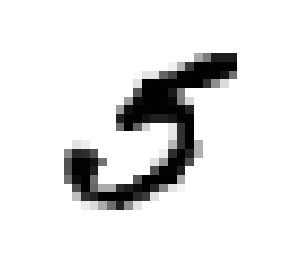

In [29]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [30]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [4]:
# Split dataset of 70000 into 60000 train and 10000 test. Shuffle them.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

In [42]:
# classify 4 and not 4, convert column into array by ravel
y_train_4 = (y_train == 4).ravel()
y_test_4 = (y_test == 4).ravel()

In [43]:
# Use Stochastic Gradient Descent classifier, it is efficient and easy to tune, but sensitive to feature scaling
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False)

In [44]:
# Some digit plotted as 4 should be predicted as False
sgd_clf.predict([some_digit])

array([False])

In [46]:
# For 3 runs of cross validation, return accuracy score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.96410179, 0.98015   , 0.97339867])

In [47]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

In [48]:
# Get the confusion matrix, rows are predicted and columns are actual`
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4, y_train_pred)

array([[53278,   880],
       [  767,  5075]], dtype=int64)

In [50]:
# Get the precision and recall, can also be calculated from confusion matrix
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_4, y_train_pred), recall_score(y_train_4, y_train_pred)

(0.852225020990764, 0.8687093461143444)

In [51]:
# Get the function scores of the predicted values
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3,method="decision_function")

Saving figure precision_recall_vs_threshold_plot


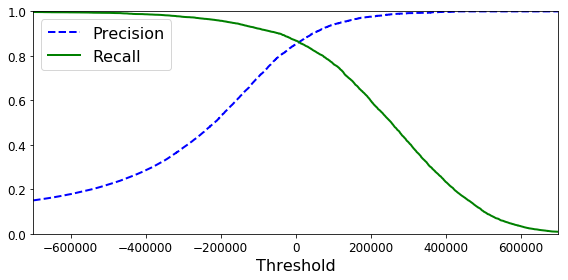

In [53]:
# Plot the curve of precision and recall versus threshold
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure roc_curve_plot


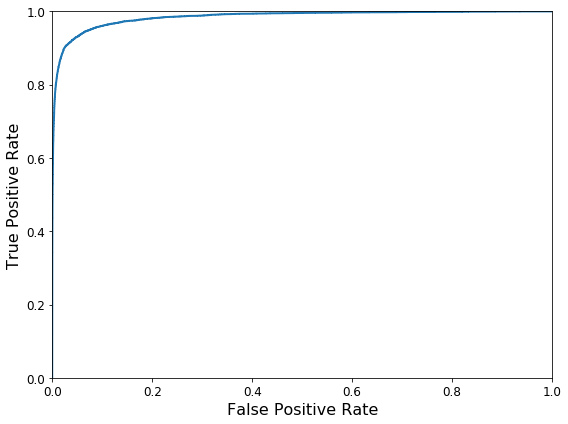

In [57]:
# Use receiver operating characteristic (ROC) curve to show recall and false positive tradeoff
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.9842328655607044

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3, method="predict_proba")

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Saving figure roc_curve_comparison_plot


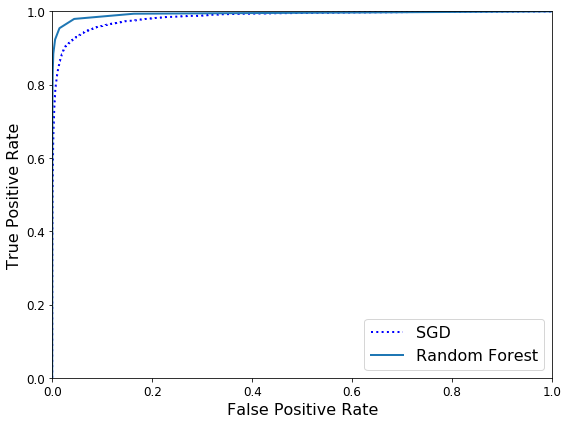

In [62]:
# Compare SGD and random forest classifiers by ROC curve
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4,y_scores_forest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [64]:
# Random forest precision is much higher but recall is lower than SGD classifier (0.852 and 0.868 respectively)
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3)
precision_score(y_train_4, y_train_pred_forest),recall_score(y_train_4, y_train_pred_forest)

(0.9896003262642741, 0.8307086614173228)

## Multiclass classification

In [66]:
# Use binary classifier will need one versus one to cover all combinations
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train.ravel())

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False),
          n_jobs=1)

In [67]:
# One versus one has 9*10/2 combinations
len(ovo_clf.estimators_)

45

In [69]:
forest_clf.fit(X_train, y_train.ravel())
forest_clf.predict([some_digit])

array([5.])

In [70]:
# Use multiclassifier can have probability of all the labels
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [72]:
# Standard scaler is less affected by outliner than min max scaler, but could be a problem to some algorithms like neural network
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train.ravel(), cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

## Multilabel classification

In [74]:
# KNN is non-parametric, instance-based. It is simple but computationally expensive
from sklearn.neighbors import KNeighborsClassifier
y_train_small = (y_train <=3)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_small, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [75]:
# This cell takes long time (several hours) to show how computationally expensive it is 
cross_val_score(knn_clf, X_train, y_multilabel, cv=3, scoring="accuracy")

array([0.97355, 0.9748 , 0.97475])

## Tuning hyperparameters

In [77]:
# Take 6 hours to go through the grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200,500],
    'max_features': [.5,.7],
    'bootstrap': [False, True],
    'max_depth':[3,6]}
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train.ravel())    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 86.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 371.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 500], 'max_features': [0.5, 0.7], 'bootstrap': [False, True], 'max_depth': [3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [78]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 6, 'max_features': 0.5, 'n_estimators': 500}

In [79]:
grid_search.best_score_

0.8666666666666667

In [82]:
cross_val_score(forest_clf, X_train, y_train.ravel(), cv=3, scoring="accuracy")

array([0.94321136, 0.94104705, 0.94084113])

## Data augmentation

In [8]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

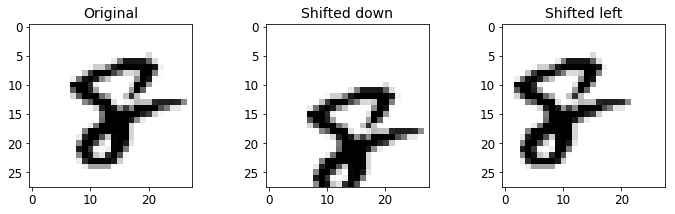

In [8]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [9]:
# Augment data by shifting the images by 1 

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [10]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# Use the best hyperparameters obtained from last section
from sklearn.ensemble import RandomForestClassifier
best_params_={'bootstrap': True, 'max_depth': 6, 'max_features': 0.5, 'n_estimators': 500}
forest_clf = RandomForestClassifier(**best_params_)
forest_clf.fit(X_train_augmented, y_train_augmented.ravel())

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train_augmented, y_train_augmented.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [12]:
y_knn_pred = knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9763